In [1]:
!pip install torch torchvision matplotlib

# Imports & Device Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# Data Augmentation + Normalization

In [2]:
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=15),      # rotate ±15°
    transforms.RandomAffine(0, scale=(0.9, 1.1)),  # scaling
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.10MB/s]


In [4]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32*7*7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNIST_CNN().to(device)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
num_epochs = 5  # increase to 10–15 for better accuracy
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Epoch [1/5] Loss: 0.2387
Epoch [2/5] Loss: 0.0809
Epoch [3/5] Loss: 0.0597
Epoch [4/5] Loss: 0.0498
Epoch [5/5] Loss: 0.0428


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

accuracy = (all_preds == all_labels).sum().item() / len(all_labels)
print(f'Test Accuracy: {accuracy*100:.2f}%')



Test Accuracy: 99.24%


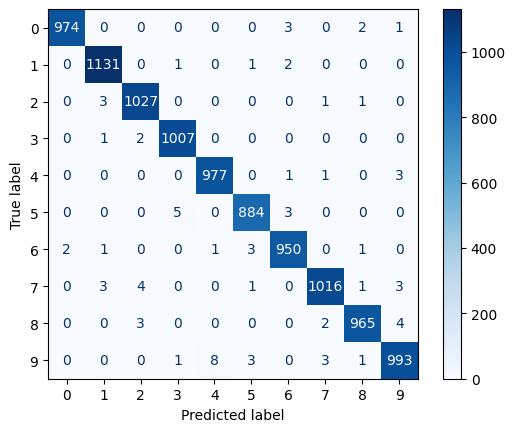

In [8]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

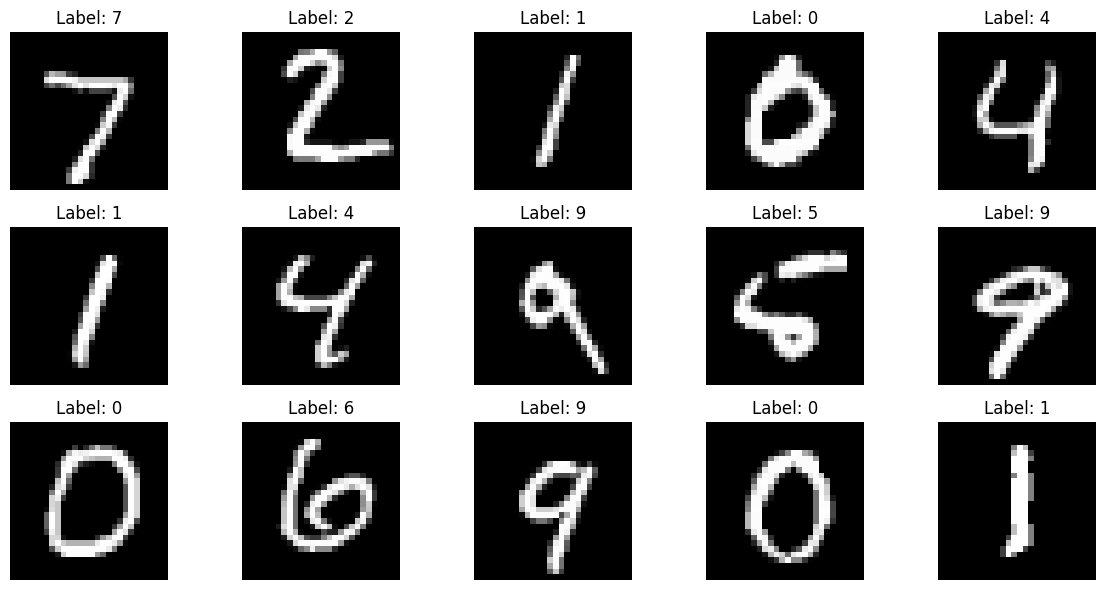

In [9]:
fig, axes = plt.subplots(3, 5, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    img = test_dataset[i][0].squeeze().numpy()
    label = test_dataset[i][1]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()
